In [68]:
pip install tensorflow keras keras-tuner scikit-learn pandas matplotlib seaborn


# Car Insurance Claim Prediction with MLP Full Deep Learning Pipeline

#   Import Libraries

In [69]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, initializers
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt


#   Load Dataset

In [71]:
df = pd.read_csv("/content/car_insurance_claim.csv")  # Ensure correct file path

#   Data Preprocessing

In [72]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   BIRTH       10302 non-null  object 
 3   AGE         10295 non-null  float64
 4   HOMEKIDS    10302 non-null  int64  
 5   YOJ         9754 non-null   float64
 6   INCOME      9732 non-null   object 
 7   PARENT1     10302 non-null  object 
 8   HOME_VAL    9727 non-null   object 
 9   MSTATUS     10302 non-null  object 
 10  GENDER      10302 non-null  object 
 11  EDUCATION   10302 non-null  object 
 12  OCCUPATION  9637 non-null   object 
 13  TRAVTIME    10302 non-null  int64  
 14  CAR_USE     10302 non-null  object 
 15  BLUEBOOK    10302 non-null  object 
 16  TIF         10302 non-null  int64  
 17  CAR_TYPE    10302 non-null  object 
 18  RED_CAR     10302 non-null  object 
 19  OLDCLAIM    10302 non-nul

In [73]:
print(df.describe())

                 ID      KIDSDRIV           AGE      HOMEKIDS          YOJ  \
count  1.030200e+04  10302.000000  10295.000000  10302.000000  9754.000000   
mean   4.956631e+08      0.169288     44.837397      0.720443    10.474062   
std    2.864675e+08      0.506512      8.606445      1.116323     4.108943   
min    6.317500e+04      0.000000     16.000000      0.000000     0.000000   
25%    2.442869e+08      0.000000     39.000000      0.000000     9.000000   
50%    4.970043e+08      0.000000     45.000000      0.000000    11.000000   
75%    7.394551e+08      0.000000     51.000000      1.000000    13.000000   
max    9.999264e+08      4.000000     81.000000      5.000000    23.000000   

           TRAVTIME           TIF      CLM_FREQ       MVR_PTS      CAR_AGE  \
count  10302.000000  10302.000000  10302.000000  10302.000000  9663.000000   
mean      33.416424      5.329159      0.800718      1.710153     8.298148   
std       15.869687      4.110795      1.154079      2.159015  

In [74]:

print(df.isnull().sum())

ID              0
KIDSDRIV        0
BIRTH           0
AGE             7
HOMEKIDS        0
YOJ           548
INCOME        570
PARENT1         0
HOME_VAL      575
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION    665
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE       639
CLAIM_FLAG      0
URBANICITY      0
dtype: int64


# Numerical Columns

In [75]:
num_cols = ['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'CAR_AGE']
for col in num_cols:
    df[col] = df[col].replace('[\\$,]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].median(), inplace=True)


In [76]:
df['OCCUPATION'].fillna('Unknown', inplace=True)


In [77]:
df.drop(columns=["ID"], inplace=True, errors='ignore')

In [78]:

df['BIRTH'] = pd.to_datetime(df['BIRTH'], format='%d%b%y', errors='coerce')
df['AGE_FROM_BIRTH'] = 2024 - df['BIRTH'].dt.year
df.drop(columns=['BIRTH'], inplace=True)

In [79]:
# Convert currency fields to float
currency_cols = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
for col in currency_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

#   Categorical columns

In [80]:

categorical_cols = [
    'PARENT1', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
    'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY'
]

In [81]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df.dropna(inplace=True)

# Splitting

In [82]:

X = df.drop("CLAIM_FLAG", axis=1)
y = df["CLAIM_FLAG"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scaling

In [83]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#   Baseline Perceptron

In [84]:

baseline = keras.Sequential([
    layers.Dense(1, activation="sigmoid", input_shape=(X_train_scaled.shape[1],))
])
baseline.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
baseline.fit(X_train_scaled, y_train, epochs=10, validation_split=0.2, verbose=0)
print("Baseline Evaluation:", baseline.evaluate(X_test_scaled, y_test))

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9084 - loss: 0.3046
Baseline Evaluation: [0.3118744194507599, 0.89422607421875]


#   Define MLP with Tuner

In [85]:

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            hp.Int(f"units_{i}", 64, 256, step=64),
            activation='relu',
            kernel_initializer='he_normal',                #  Weight Intialization using  He
            kernel_regularizer=regularizers.l2(hp.Float("l2", 1e-5, 1e-2, sampling='log'))
        ))
        model.add(layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1)))          #   Drop outs

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop"]),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [86]:
import shutil
import os

# ⚠️ Step 1: Clean tuner cache to avoid shape mismatch
if os.path.exists("keras_tuner"):
    shutil.rmtree("keras_tuner")

# ✅ Step 2: Create a fresh tuner with a new project name
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="keras_tuner",
    project_name="car_insurance_fresh"  # <-- new name avoids old tuner reuse
)

# Step 3: Train   <---  Early stopping Used
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=2)
best_model = tuner.get_best_models(1)[0]


Trial 5 Complete [00h 00m 42s]
val_accuracy: 0.9933292865753174

Best val_accuracy So Far: 0.9975742697715759
Total elapsed time: 00h 03m 32s


#   Train Final Model

Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9941 - loss: 0.0470 - val_accuracy: 0.9918 - val_loss: 0.0502
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9934 - loss: 0.0476 - val_accuracy: 0.9932 - val_loss: 0.0447
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 0.0424 - val_accuracy: 0.9942 - val_loss: 0.0421
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9946 - loss: 0.0440 - val_accuracy: 0.9947 - val_loss: 0.0440
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9939 - loss: 0.0448 - val_accuracy: 0.9956 - val_loss: 0.0439
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9949 - loss: 0.0419 - val_accuracy: 0.9951 - val_loss: 0.0371
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9943 - loss: 0.0438 - val_accuracy: 0.9947 - val_loss: 0.0370
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9955 - loss: 0.0392 - val_accuracy: 0.

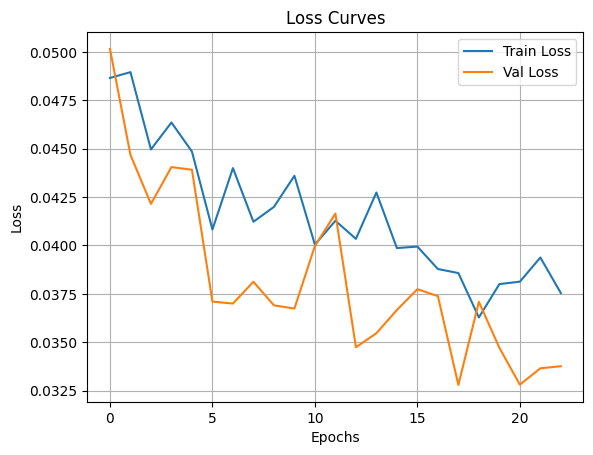

In [87]:

history = best_model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test), callbacks=[early_stop])


# Plotting Loss , validation_loss

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.grid(True)
plt.show()


Loss and validation loss difference is low so it is not overfitting

#  Evaluatation

In [88]:

loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
y_pred = (best_model.predict(X_test_scaled) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))




65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0326
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1506
           1       1.00      0.98      0.99       555

    accuracy                           1.00      2061
   macro avg       1.00      0.99      0.99      2061
weighted avg       1.00      1.00      1.00      2061

Confusion Matrix:
 [[1506    0]
 [   9  546]]
ROC-AUC Score: 0.991891891891892


In [89]:
# Save trained model
best_model.save("car_insurance_mlp_best_model.h5")

# Save the scaler
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [90]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib


model = load_model("car_insurance_mlp_best_model.h5")
scaler = joblib.load("scaler.pkl")

#input
input_data = {
    'KIDSDRIV': 1,
    'AGE': 40,
    'HOMEKIDS': 0,
    'YOJ': 12,
    'INCOME': 60000.0,
    'HOME_VAL': 180000.0,
    'TRAVTIME': 25,
    'BLUEBOOK': 15000.0,
    'TIF': 3,
    'OLDCLAIM': 0.0,
    'CLM_FREQ': 0,
    'MVR_PTS': 2,
    'CLM_AMT': 0.0,
    'CAR_AGE': 5,

    # One-hot encoded categorical features like:
    'PARENT1_Yes': 1,
    'MSTATUS_Yes': 1,
    'GENDER_M': 1,
    'EDUCATION_Bachelors': 1,
    'OCCUPATION_Professional': 1,
    'CAR_USE_Private': 1,
    'CAR_TYPE_SUV': 1,
    'RED_CAR_Yes': 0,
    'REVOKED_Yes': 0,
    'URBANICITY_Urban': 1,
}

input_df = pd.DataFrame([input_data])

for col in X_train.columns:
    if col not in input_df.columns:
        input_df[col] = 0
input_df = input_df[X_train.columns]

scaled_input = scaler.transform(input_df)

prediction = model.predict(scaled_input)
predicted_class = int(prediction[0][0] > 0.5)
confidence = float(prediction[0][0])

print(f"Prediction: {'CLAIM' if predicted_class == 1 else 'NO CLAIM'}")
print(f"Confidence: {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediction: NO CLAIM
Confidence: 0.0015
